## DATA301 Individual Project

Question: How much information do I lose when I predict anemia using variables that are easier to measure and less invasive with respect to predictions based on blood tests?

In [165]:
import pandas as pd
import numpy as np
import xport
import sklearn
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [63]:
# More Datasets from 2015-2016 to supplement our study:
with open('2015-2016/CBC_I.XPT', 'rb') as f:
    hemo1 = pd.read_sas(f, format='xport')

with open('2015-2016/DEMO_I.XPT', 'rb') as f:
    demo1 = pd.read_sas(f, format='xport')

# Chromium and cobalt
with open('2015-2016/CRCO_I.XPT', 'rb') as f:
    crco1 = pd.read_sas(f, format='xport')

# Lead, Cadmium, Total Mercury, Selenium, & Manganese - Blood
with open('2015-2016/PBCD_I.XPT', 'rb') as f:
    pbcd1 = pd.read_sas(f, format='xport')

# Mercury: Inorganic, Ethyl and Methyl - Blood
with open('2015-2016/IHGEM_I.XPT', 'rb') as f:
    ihgem1 = pd.read_sas(f, format='xport')

# insulin
with open('2015-2016/INS_I.XPT', 'rb') as f:
    ins1 = pd.read_sas(f, format='xport')

# Volatile Organic Compounds and Trihalomethanes/MTBE - Blood
with open('2015-2016/VOCWB_I.XPT', 'rb') as f:
    vocwb1 = pd.read_sas(f, format='xport')

# Cholesterol - Low-Density Lipoproteins (LDL) & Triglycerides
with open('2015-2016/TRIGLY_I.XPT', 'rb') as f:
    trigly1 = pd.read_sas(f, format='xport')
    
# Cholesterol - High - Density Lipoprotein (HDL)
with open('2015-2016/HDL_I.XPT', 'rb') as f:
    hdl1 = pd.read_sas(f, format='xport')
    
# Vitamin D
with open('2015-2016/VID_I.XPT', 'rb') as f:
    vid1 = pd.read_sas(f, format='xport')

with open('2015-2016/CBC_I.XPT', 'rb') as f:
    df_cbc = pd.read_sas(f, format='xport')

# Read Dietary Interview, Total Nutrient Intakes 
with open('2015-2016/DR1TOT_I.XPT', 'rb') as f:
    df_dr1tot = pd.read_sas(f, format='xport')

# Read Biochemistry profile 
with open('2015-2016/BIOPRO_I.XPT', 'rb') as f:
    df_biopro = pd.read_sas(f, format='xport')

# Read Medical Conditions 
with open('2015-2016/MCQ_I.XPT', 'rb') as f:
    df_mcq = pd.read_sas(f, format='xport')

# Read Physical Activity  
with open('2015-2016/PAQ_I.XPT', 'rb') as f:
    df_paq = pd.read_sas(f, format='xport')

# Read Body Measurements 
with open('2015-2016/BMX_I.XPT', 'rb') as f:
    df_bmx = pd.read_sas(f, format='xport')
    

c:\Users\dl668\anaconda3\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


In [64]:
# function to filter out columns and rows with too many NAs, threshold is 40% NAs in either the column or the row:
def naFilter(dataset):
    for i in dataset:
        if dataset[i].isna().sum()/len(dataset) > 0.5:
            dataset = dataset.drop(i, axis='columns')
    for i in range(len(dataset)):
        if dataset.loc[i].isna().sum()/len(dataset.loc[i]) > 0.5:
            dataset = dataset.drop(i)
    return dataset

# function to extract categorical and numerical column names
def catNamesAndNumNames(dataset):
    catNames = []
    numNames = []
    for i in dataset:
        if i == 'Anemia':
            pass
        elif len(pd.unique(dataset[i])) < 11:
                catNames.append(i)
        else:
            numNames.append(i)
    return catNames, numNames

In [65]:
combinedLabData2 = pd.merge(hemo1, demo1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, pbcd1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, ihgem1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, ins1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, vocwb1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, trigly1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, hdl1, on='SEQN', how='left')
combinedLabData2 = pd.merge(combinedLabData2, vid1, on='SEQN', how='left')

In [66]:
combinedLabData2 

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,...,LBDHDD,LBDHDDSI,LBXVIDMS,LBDVIDLC,LBXVD2MS,LBDVD2LC,LBXVD3MS,LBDVD3LC,LBXVE3MS,LBDVE3LC
0,83732.0,9.8,23.9,8.2,63.5,4.000000e+00,0.5,2.3,0.8,6.2,...,46.0,1.19,76.1,5.397605e-79,1.45,1.000000e+00,74.7,5.397605e-79,4.70,5.397605e-79
1,83733.0,7.3,31.3,9.7,54.8,2.600000e+00,1.8,2.3,0.7,4.0,...,63.0,1.63,56.5,5.397605e-79,1.45,1.000000e+00,55.1,5.397605e-79,3.51,5.397605e-79
2,83734.0,4.4,29.9,9.6,55.8,3.900000e+00,0.9,1.3,0.4,2.5,...,30.0,0.78,87.5,5.397605e-79,1.45,1.000000e+00,86.1,5.397605e-79,8.89,5.397605e-79
3,83735.0,6.1,17.1,10.3,68.7,3.100000e+00,0.9,1.0,0.6,4.2,...,61.0,1.58,38.4,5.397605e-79,1.45,1.000000e+00,37.0,5.397605e-79,3.08,5.397605e-79
4,83736.0,4.2,47.1,7.8,44.8,2.000000e-01,0.2,2.0,0.3,1.9,...,53.0,1.37,58.7,5.397605e-79,1.45,1.000000e+00,57.3,5.397605e-79,3.33,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9160,93698.0,8.7,49.9,11.8,37.5,5.397605e-79,1.0,4.3,1.0,3.3,...,NaN,NaN,58.2,5.397605e-79,1.45,1.000000e+00,56.8,5.397605e-79,4.87,5.397605e-79
9161,93699.0,5.4,49.0,12.0,32.9,5.000000e+00,1.2,2.6,0.6,1.8,...,63.0,1.63,75.2,5.397605e-79,2.51,5.397605e-79,72.7,5.397605e-79,9.38,5.397605e-79
9162,93700.0,7.6,26.4,9.2,61.9,2.000000e+00,0.6,2.0,0.7,4.7,...,42.0,1.09,66.2,5.397605e-79,1.45,1.000000e+00,64.8,5.397605e-79,4.15,5.397605e-79
9163,93701.0,3.6,41.5,8.2,45.9,3.500000e+00,1.1,1.5,0.3,1.7,...,62.0,1.60,72.2,5.397605e-79,1.45,1.000000e+00,70.8,5.397605e-79,7.13,5.397605e-79


In [67]:
combinedDemoEnvdata = pd.merge(df_cbc, demo1, on='SEQN', how='left')
combinedDemoEnvdata = pd.merge(combinedDemoEnvdata, df_dr1tot, on='SEQN', how='left')
combinedDemoEnvdata = pd.merge(combinedDemoEnvdata, df_biopro, on='SEQN', how='left')
combinedDemoEnvdata = pd.merge(combinedDemoEnvdata, df_mcq, on='SEQN', how='left')
combinedDemoEnvdata = pd.merge(combinedDemoEnvdata, df_paq, on='SEQN', how='left')
combinedDemoEnvdata = pd.merge(combinedDemoEnvdata, df_bmx, on='SEQN', how='left')

In [68]:
combinedDemoEnvdata

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,...,BMXARMC,BMIARMC,BMXWAIST,BMIWAIST,BMXSAD1,BMXSAD2,BMXSAD3,BMXSAD4,BMDAVSAD,BMDSADCM
0,83732.0,9.8,23.9,8.2,63.5,4.000000e+00,0.5,2.3,0.8,6.2,...,35.9,NaN,101.1,NaN,22.9,22.7,NaN,NaN,22.8,NaN
1,83733.0,7.3,31.3,9.7,54.8,2.600000e+00,1.8,2.3,0.7,4.0,...,33.2,NaN,107.9,NaN,27.5,27.1,NaN,NaN,27.3,NaN
2,83734.0,4.4,29.9,9.6,55.8,3.900000e+00,0.9,1.3,0.4,2.5,...,31.0,NaN,116.5,NaN,26.7,26.5,NaN,NaN,26.6,NaN
3,83735.0,6.1,17.1,10.3,68.7,3.100000e+00,0.9,1.0,0.6,4.2,...,38.3,NaN,110.1,NaN,25.2,25.0,NaN,NaN,25.1,NaN
4,83736.0,4.2,47.1,7.8,44.8,2.000000e-01,0.2,2.0,0.3,1.9,...,27.2,NaN,80.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9160,93698.0,8.7,49.9,11.8,37.5,5.397605e-79,1.0,4.3,1.0,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9161,93699.0,5.4,49.0,12.0,32.9,5.000000e+00,1.2,2.6,0.6,1.8,...,20.7,NaN,62.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9162,93700.0,7.6,26.4,9.2,61.9,2.000000e+00,0.6,2.0,0.7,4.7,...,30.6,NaN,98.9,NaN,21.7,21.8,NaN,NaN,21.8,NaN
9163,93701.0,3.6,41.5,8.2,45.9,3.500000e+00,1.1,1.5,0.3,1.7,...,20.8,NaN,62.7,NaN,14.3,14.0,NaN,NaN,14.2,NaN


In [69]:
combinedLabData2 = naFilter(combinedLabData2)
catVars, numVars = catNamesAndNumNames(combinedLabData2)
combinedDemoEnvdata = naFilter(combinedDemoEnvdata)
catVars2, numVars2 = catNamesAndNumNames(combinedDemoEnvdata)

In [70]:
catlabdata = combinedLabData2[catVars]
numlabdata = combinedLabData2[numVars]
catDemoEnvdata = combinedDemoEnvdata[catVars2]
numDemoEnvdata = combinedDemoEnvdata[numVars2]

In [71]:
# Create an imputer object with a median filling strategy
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Apply the imputer to the numerical data
numlabdataimputed = pd.DataFrame(imputer_num.fit_transform(numlabdata), columns=numlabdata.columns)

# Impute missing values with the mode for each column
catlabdataimputed = pd.DataFrame(imputer_cat.fit_transform(catlabdata), columns=catlabdata.columns)

# Apply the imputer to the numerical data
numDemoEnvdataimputed = pd.DataFrame(imputer_num.fit_transform(numDemoEnvdata), columns=numDemoEnvdata.columns)

# Impute missing values with the mode for each column
catDemoEnvdataimputed = pd.DataFrame(imputer_cat.fit_transform(catDemoEnvdata), columns=catDemoEnvdata.columns)

In [72]:
combinedLabDataImputed2 = pd.concat([numlabdataimputed, catlabdataimputed], axis=1)
combinedLabDataImputed2 = naFilter(combinedLabDataImputed2.reset_index())
combinedLabDataImputed2 = combinedLabDataImputed2.reset_index()
combinedLabDataImputed2 = naFilter(combinedLabDataImputed2)
combinedLabDataImputed2 = combinedLabDataImputed2.drop(['level_0', 'index'], axis = 1)
combinedDemoEnvdata = pd.concat([numDemoEnvdataimputed, catDemoEnvdataimputed], axis=1)
combinedDemoEnvdata = naFilter(combinedDemoEnvdata.reset_index())
combinedDemoEnvdata = combinedDemoEnvdata.reset_index()
combinedDemoEnvdata= naFilter(combinedDemoEnvdata)
combinedDemoEnvdata = combinedDemoEnvdata.drop(['level_0', 'index'], axis = 1)

In [73]:
combinedLabDataImputed = pd.read_csv('combinedLabData.csv')
combinedDemoEnvDataFinalTest = pd.read_csv('combined_data_imputed_final_test.csv')

In [101]:
combinedLabDataImputed2

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,...,LBDTHGLC,LBDBSELC,LBDBMNLC,LBDIHGLC,LBDBGELC,LBDBGMLC,LBDVIDLC,LBDVD2LC,LBDVD3LC,LBDVE3LC
0,83732.0,9.8,23.9,8.2,63.5,4.000000e+00,0.5,2.3,0.8,6.2,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
1,83733.0,7.3,31.3,9.7,54.8,2.600000e+00,1.8,2.3,0.7,4.0,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
2,83734.0,4.4,29.9,9.6,55.8,3.900000e+00,0.9,1.3,0.4,2.5,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
3,83735.0,6.1,17.1,10.3,68.7,3.100000e+00,0.9,1.0,0.6,4.2,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
4,83736.0,4.2,47.1,7.8,44.8,2.000000e-01,0.2,2.0,0.3,1.9,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,93698.0,8.7,49.9,11.8,37.5,5.397605e-79,1.0,4.3,1.0,3.3,...,1.000000e+00,5.397605e-79,5.397605e-79,1.0,1.0,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
8154,93699.0,5.4,49.0,12.0,32.9,5.000000e+00,1.2,2.6,0.6,1.8,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
8155,93700.0,7.6,26.4,9.2,61.9,2.000000e+00,0.6,2.0,0.7,4.7,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79
8156,93701.0,3.6,41.5,8.2,45.9,3.500000e+00,1.1,1.5,0.3,1.7,...,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79


In [74]:
combinedDemoEnvDataFinalTest['SEQN'] = combinedDemoEnvDataFinalTest['SEQN.1']
combinedDemoEnvDataFinalTest = combinedDemoEnvDataFinalTest.drop(['SEQN.1'], axis=1)

In [75]:
anemia = []
for i in range(len(combinedLabDataImputed)):
    if combinedLabDataImputed ['DMDHRGND'][i] == 1 and combinedLabDataImputed ['LBXHGB'][i] < 13:
        anemia.append('True')
    elif combinedLabDataImputed ['DMDHRGND'][i] == 2 and combinedLabDataImputed ['LBXHGB'][i] < 12:
        anemia.append('True')
    else:
        anemia.append('False')
combinedLabDataImputed['Anemia'] = anemia

In [76]:
len(combinedLabDataImputed)

1504

In [77]:
combinedLabDataImputed

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXEOPCT,LBXBAPCT,LBDMONO,LBDNENO,LBDEONO,LBXRBCSI,...,LBDBMNLC,LBDIHGLC,LBDBGELC,LBDBGMLC,LBDVIDLC,LBDVD2LC,LBDVD3LC,LBDVE3LC,LBDVICLC,Anemia
0,97785.0,7.5,36.2,9.7,1.3,0.6,0.7,3.9,0.1,4.75,...,5.397605e-79,1.000000e+00,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
1,100877.0,5.2,38.6,10.0,1.4,0.6,0.5,2.6,0.1,5.10,...,5.397605e-79,1.000000e+00,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
2,95748.0,7.5,23.0,8.5,1.1,0.5,0.6,5.0,0.1,4.93,...,5.397605e-79,5.397605e-79,1.0,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
3,100639.0,7.5,34.7,9.2,2.1,0.7,0.7,4.0,0.2,4.23,...,5.397605e-79,1.000000e+00,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
4,97361.0,5.7,35.8,6.2,2.3,0.4,0.4,3.2,0.1,5.28,...,5.397605e-79,5.397605e-79,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,97020.0,9.9,31.6,8.9,4.9,0.4,0.9,5.4,0.5,5.29,...,5.397605e-79,5.397605e-79,1.0,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,False
1500,97483.0,7.8,33.6,10.0,3.4,0.9,0.8,4.1,0.3,5.62,...,5.397605e-79,1.000000e+00,1.0,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
1501,98357.0,4.6,37.9,9.3,1.6,0.4,0.4,2.3,0.1,4.70,...,5.397605e-79,1.000000e+00,1.0,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,False
1502,96590.0,5.8,32.0,8.1,1.3,0.6,0.5,3.4,0.1,4.96,...,5.397605e-79,5.397605e-79,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,False


In [89]:
seqn = combinedDemoEnvDataFinalTest['SEQN']
combinedDemoEnvDataFinalTest.pop('SEQN')
combinedDemoEnvDataFinalTest.insert(0, 'SEQN', seqn)

c:\Users\dl668\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [111]:
newDataset = combinedLabDataImputed.append(combinedLabDataImputed2, ignore_index=True)
newDataset = newDataset.reset_index()
newDemoEnvDataset = combinedDemoEnvDataFinalTest.append(combinedDemoEnvdata, ignore_index=True)
newDemoEnvDataset = newDemoEnvDataset.reset_index()

In [112]:
newDataset = newDataset.drop(['index'], axis=1)

In [113]:
newDemoEnvDataset = newDemoEnvDataset.drop(['index'], axis=1)

We have dramatically augmented the dataset with new data that wasn't in the original EDA.

In order to measure performance of our models, we will compare the models using the following performance metrics to look at how much info is gained/lost when using external factors compared to blood test info: AUC/ROC, Accuracy, Precision and Sensitivity.

In [114]:
anemiaInv = []
for i in range(len(newDataset)):
    if newDataset['DMDHRGND'][i] == 1 and newDataset['LBXHGB'][i] < 13:
        anemiaInv.append('True')
    elif newDataset['DMDHRGND'][i] == 2 and newDataset['LBXHGB'][i] < 12:
        anemiaInv.append('True')
    else:
        anemiaInv.append('False')

In [115]:
anemiaDemoEnv = []
for i in range(len(newDemoEnvDataset)):
    if newDemoEnvDataset['DMDHRGND'][i] == 1 and newDemoEnvDataset['LBXHGB'][i] < 13:
        anemiaDemoEnv.append('True')
    elif newDemoEnvDataset['DMDHRGND'][i] == 2 and newDemoEnvDataset['LBXHGB'][i] < 12:
        anemiaDemoEnv.append('True')
    else:
        anemiaDemoEnv.append('False')

In [116]:
newDataset

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXEOPCT,LBXBAPCT,LBDMONO,LBDNENO,LBDEONO,LBXRBCSI,...,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,SDMVPSU
0,97785.0,7.5,36.2,9.7,1.300000e+00,0.6,0.7,3.9,1.000000e-01,4.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100877.0,5.2,38.6,10.0,1.400000e+00,0.6,0.5,2.6,1.000000e-01,5.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,95748.0,7.5,23.0,8.5,1.100000e+00,0.5,0.6,5.0,1.000000e-01,4.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100639.0,7.5,34.7,9.2,2.100000e+00,0.7,0.7,4.0,2.000000e-01,4.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,97361.0,5.7,35.8,6.2,2.300000e+00,0.4,0.4,3.2,1.000000e-01,5.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9657,93698.0,8.7,49.9,11.8,5.397605e-79,1.0,1.0,3.3,5.397605e-79,5.05,...,7.0,7.0,3.000000e+00,5.397605e-79,1.000000e+00,2.0,1.0,2.0,5.0,1.0
9658,93699.0,5.4,49.0,12.0,5.000000e+00,1.2,0.6,1.8,3.000000e-01,4.59,...,5.0,5.0,5.397605e-79,2.000000e+00,1.000000e+00,1.0,5.0,1.0,5.0,1.0
9659,93700.0,7.6,26.4,9.2,2.000000e+00,0.6,0.7,4.7,2.000000e-01,5.01,...,5.0,5.0,5.397605e-79,3.000000e+00,5.397605e-79,2.0,1.0,1.0,1.0,1.0
9660,93701.0,3.6,41.5,8.2,3.500000e+00,1.1,0.3,1.7,1.000000e-01,5.29,...,4.0,4.0,5.397605e-79,2.000000e+00,5.397605e-79,1.0,5.0,1.0,5.0,2.0


In [117]:
newDemoEnvDataset

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,...,MCQ365A,MCQ365B,MCQ365C,MCQ365D,MCQ370A,MCQ370B,MCQ370C,MCQ370D,PAQ710,PAQ715
0,97038.0,8.2,39.1,8.3,51.2,9.000000e-01,0.7,3.2,0.7,4.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96457.0,8.0,24.1,7.4,64.3,3.600000e+00,0.7,1.9,0.6,5.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96375.0,4.6,42.7,9.6,46.0,1.000000e+00,0.8,2.0,0.4,2.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,94134.0,5.8,34.5,9.4,50.9,4.800000e+00,0.5,2.0,0.5,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96451.0,7.8,20.5,8.7,68.7,1.600000e+00,0.7,1.6,0.7,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,93698.0,8.7,49.9,11.8,37.5,5.397605e-79,1.0,4.3,1.0,3.3,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.000000e+00,8.000000e+00
9571,93699.0,5.4,49.0,12.0,32.9,5.000000e+00,1.2,2.6,0.6,1.8,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.000000e+00,8.000000e+00
9572,93700.0,7.6,26.4,9.2,61.9,2.000000e+00,0.6,2.0,0.7,4.7,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79
9573,93701.0,3.6,41.5,8.2,45.9,3.500000e+00,1.1,1.5,0.3,1.7,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.000000e+00,5.397605e-79


In order to answer our question, I will look at the performances of the models using the invasive dataset, the demographic/environmental dataset and a combination of both .

## Invasive data models:

In [167]:
#newdataset variables:
catVars, numVars = catNamesAndNumNames(newDataset.drop(['SEQN','LBXHGB','DMDHRGND','Anemia'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(newDataset.drop(['SEQN','LBXHGB','DMDHRGND','Anemia'], axis=1), anemiaInv, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe1 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe1, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',
                                                                                '...
                                                                                'SIAINTRP',
                                                                                'FIALANG', ...])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [168]:
randomSearch.best_score_ 

0.9071034133393621

In [169]:
predictions = randomSearch.best_estimator_.predict(xtest)

In [170]:
accuracy_score(ytest, predictions)

0.9105018106570099

In [171]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

       False       0.92      0.98      0.95      1534
        True       0.87      0.66      0.75       399

    accuracy                           0.91      1933
   macro avg       0.90      0.82      0.85      1933
weighted avg       0.91      0.91      0.91      1933



In [172]:
predictionsNum = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

In [173]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

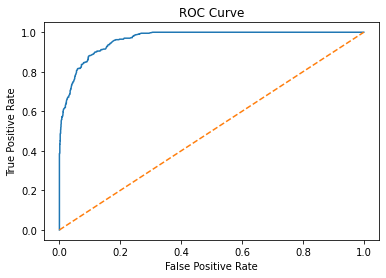

In [174]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [185]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum))
roc1 = roc_auc_score(ytestNum, predictionsNum)

ROC_AUC score:  0.9645577437727303


In [186]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum))
aucpr1 = average_precision_score(ytestNum, predictionsNum)

AUC-PR score:  0.8916579144668929


In [177]:
pipe2 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe2, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [178]:
mlpSearch.best_score_ 

0.8910598391506216

In [179]:
predictions2 = mlpSearch.best_estimator_.predict(xtest)

In [181]:
accuracy_score(ytest, predictions2)

0.8867046042421107

In [182]:
print(classification_report(ytest, predictions2))

              precision    recall  f1-score   support

       False       0.90      0.97      0.93      1534
        True       0.82      0.57      0.68       399

    accuracy                           0.89      1933
   macro avg       0.86      0.77      0.80      1933
weighted avg       0.88      0.89      0.88      1933



In [183]:
predictionsNum2 = mlpSearch.best_estimator_.predict_proba(xtest)[:, 1]

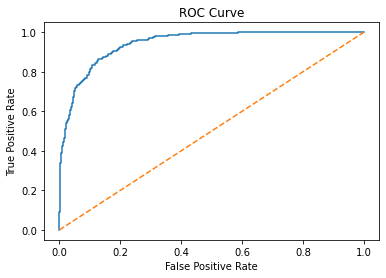

In [184]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum2)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [187]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum2))
roc2 = roc_auc_score(ytestNum, predictionsNum2)

ROC_AUC score:  0.9434766838870318


In [188]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum2))
aucpr2 = average_precision_score(ytestNum, predictionsNum2)

AUC-PR score:  0.8292108758676223


In [189]:
pipe3 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe3, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB'...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [190]:
gradSearch.best_score_

0.9205601619422342

In [191]:
predictions3 = gradSearch.best_estimator_.predict(xtest)

In [192]:
accuracy_score(ytest, predictions3)

0.9192964304190377

In [193]:
print(classification_report(ytest, predictions3))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95      1534
        True       0.85      0.74      0.79       399

    accuracy                           0.92      1933
   macro avg       0.89      0.85      0.87      1933
weighted avg       0.92      0.92      0.92      1933



In [194]:
predictionsNum3 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

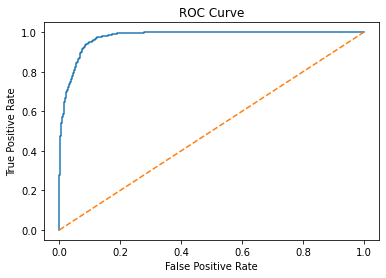

In [195]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum3)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [196]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum3))
roc3 = roc_auc_score(ytestNum, predictionsNum3)

ROC_AUC score:  0.9760450670352543


In [197]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum3))
aucpr3 = average_precision_score(ytestNum, predictionsNum3)

AUC-PR score:  0.9148248041267188


## Demographic/environmental dataset

In [199]:
#newdataset variables:
catVars, numVars = catNamesAndNumNames(newDemoEnvDataset.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(newDemoEnvDataset.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1), anemiaDemoEnv, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe4 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe4, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXNEPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDLYMNO',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXHCT',
                                                                                'LBXMCVSI',
                                                                                'LBXMCHSI',
                                                                                'LBXMC...
                                                                                'MCQ300A',
                                                                                'MCQ366A', ...])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [200]:
randomSearch.best_score_ 

0.916579634464752

In [201]:
predictions4 = randomSearch.best_estimator_.predict(xtest)

In [202]:
accuracy_score(ytest, predictions4)

0.9180156657963446

In [203]:
print(classification_report(ytest, predictions4))

              precision    recall  f1-score   support

       False       0.92      0.98      0.95      1572
        True       0.89      0.62      0.73       343

    accuracy                           0.92      1915
   macro avg       0.90      0.80      0.84      1915
weighted avg       0.92      0.92      0.91      1915



In [205]:
predictionsNum4 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

In [207]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

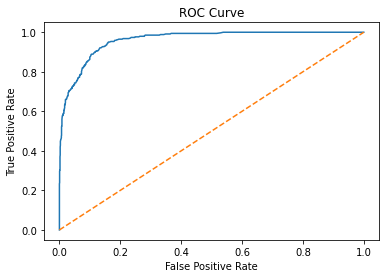

In [208]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum4)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [209]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum4))
roc4 = roc_auc_score(ytestNum, predictionsNum4)

ROC_AUC score:  0.9606961105052708


In [210]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum4))
aucpr4 = average_precision_score(ytestNum, predictionsNum4)

AUC-PR score:  0.8666145111508181


In [211]:
pipe5 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe5, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXNEPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDLYMNO',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXHCT',
                                                                                'LBXMCVSI',
                                                                                'LBXMCHSI',
                                                                                'LBXM...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [213]:
mlpSearch.best_score_

0.9020887728459531

In [214]:
predictions5 = mlpSearch.best_estimator_.predict(xtest)

In [215]:
accuracy_score(ytest, predictions5)

0.9091383812010444

In [216]:
print(classification_report(ytest, predictions5))

              precision    recall  f1-score   support

       False       0.93      0.96      0.95      1572
        True       0.80      0.66      0.72       343

    accuracy                           0.91      1915
   macro avg       0.86      0.81      0.83      1915
weighted avg       0.91      0.91      0.91      1915



In [217]:
predictionsNum5 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

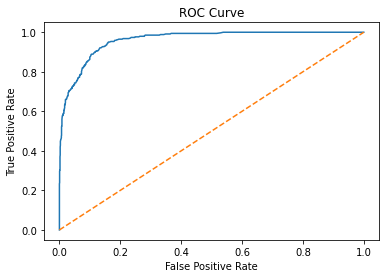

In [218]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum5)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [219]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum5))
roc5 = roc_auc_score(ytestNum, predictionsNum5)

ROC_AUC score:  0.9606961105052708


In [220]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum5))
aucpr5 = average_precision_score(ytestNum, predictionsNum5)

AUC-PR score:  0.8666145111508181


In [221]:
pipe6 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe6, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXNEPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDLYMNO',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXHCT',
                                                                                'LBXMCVSI',
                                                                                'LBXMCHSI',
                                                                                'LBX...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [222]:
gradSearch.best_score_

0.9317232375979112

In [223]:
predictions6 = gradSearch.best_estimator_.predict(xtest)

In [224]:
accuracy_score(ytest, predictions6)

0.9326370757180157

In [225]:
print(classification_report(ytest, predictions6))

              precision    recall  f1-score   support

       False       0.95      0.96      0.96      1572
        True       0.83      0.79      0.81       343

    accuracy                           0.93      1915
   macro avg       0.89      0.88      0.88      1915
weighted avg       0.93      0.93      0.93      1915



In [226]:
predictionsNum6 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

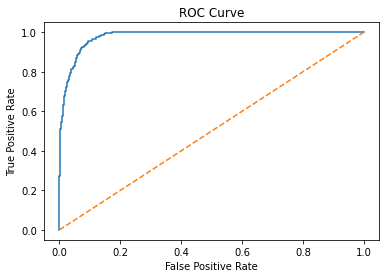

In [227]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum6)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [228]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum6))
roc6 = roc_auc_score(ytestNum, predictionsNum6)

ROC_AUC score:  0.979226477941231


In [229]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum6))
aucpr6 = average_precision_score(ytestNum, predictionsNum6)

AUC-PR score:  0.913251261793029
